### Descripción del proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba.

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

1. 
* Descarga y prepara los datos.
* Explica el procedimiento.

In [40]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Loan dataset
churn = pd.read_csv('Churn.csv')

# Show general info from the dataset
print(churn.info())
# Shows the first 5 rows for the dataset
display(churn.head())
# Counts the clients gone vs not gone
print(churn['Exited'].value_counts(normalize=True))

# Get mean for NaN values on 'Tenure' characteristic
churn['Tenure'] = churn['Tenure'].fillna(churn['Tenure'].median())

# Eliminates caracterisics unuseful for the models
churn = churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Data separation features and target
features = churn.drop('Exited', axis=1)
target = churn['Exited']

# Use HOE to codify categorycal variables
features = pd.get_dummies(features, columns=['Geography', 'Gender'], drop_first=True)

# Divide data for test
features_temp, features_test, target_temp, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target
)

# Divide data for train and validation
features_train, features_valid, target_train, target_valid = train_test_split(
    features_temp, target_temp, test_size=0.25, random_state=12345, stratify=target_temp
)

# Scalate variables
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


Found that are only Null Values in "Tenure" characteristic, however is minimal, I decided to leave it as it is, also discover that RowNumber, CustomerId and Surname are columns that do not contribute with nothing relevant for the ML model to apply, I divide the feature characteristic from the Target characteristic, then I codify the columns with object datatype using HOE.

2. 
* Examina el equilibrio de clases.
* Entrena el modelo sin tener en cuenta el desequilibrio.
* Describe brevemente tus hallazgos.

Distribucion de clases(0 = permanecen, 1 = se fueron)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Visualizacion de clases



KeyboardInterrupt: 

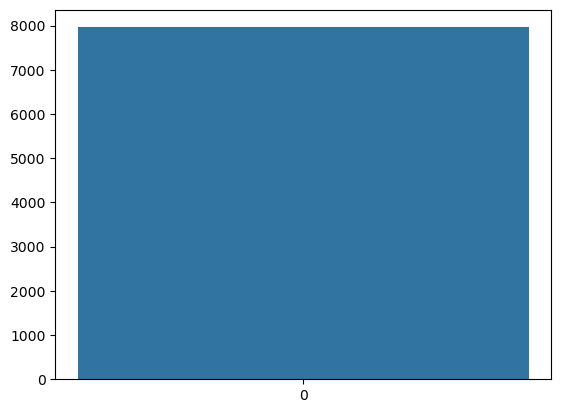

In [41]:
# Class balance to know what clients are already out of business
class_frequency = target.value_counts(normalize=True)
print('Distribucion de clases(0 = permanecen, 1 = se fueron)\n')
print(class_frequency)

# Visualization
print("\nVisualizacion de clases\n")
sns.countplot(x=target)
plt.title("Distribucion de clases")
plt.xlabel('Exited')
plt.ylabel("Cantidad")
plt.show()

# Train model w/o adjusting the balance
model = LogisticRegression(random_state=12345)
model.fit(features_train_scaled, target_train)

# Validate prediction
predicted_valid = model.predict(features_valid_scaled)
predicted_valid_proba = model.predict_proba(features_valid_scaled)[:,1]

f1 =f1_score(target_valid, predicted_valid)
auc = roc_auc_score(target_valid, predicted_valid_proba)

print(f"F1 score (sin balanceo): {f1:.3f}")
print(f"AUC-ROC score: {auc:.3f}\n")
print(classification_report(target_valid, predicted_valid))

# Threshold adjusted
threshold = 0.4
preds_adjusted = (predicted_valid_proba >= threshold).astype(int)

# New metrics withwith adjusted threshold
f1_adjusted = f1_score(target_valid, preds_adjusted)
precision_adjusted = precision_score(target_valid, preds_adjusted)
recall_adjusted = recall_score(target_valid, preds_adjusted)

print(f'--- Results with threshold value: {threshold} ---')
print(f'F1 score ajustado: {f1_adjusted: .3f}')
print(f'Precision ajustada: {precision_adjusted: .3f}')
print(f'Recall: {recall_adjusted: .3f}')

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = [f1_score(target_valid, (predicted_valid_proba >= t).astype(int))for t in thresholds]

plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

While reviewing the target variable found that approximately 20% of the bank clients are out og business, so I train a Logic Regression model without using any balance technique and found that the F1 value is low as expected since the model tends to predict the mayority class to minimize the error.

The AUC-ROC value do not fit the minimum value (0.59), so that indicates we need to work in balace techniques to detect a more accurate information of clients that left the bank.

3. 
* Mejora la calidad del modelo.
* Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases.
* Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros.
* Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor.
* Describe brevemente tus hallazgos.

F1 Score por fold:  [0.48178138 0.54789272 0.51807229 0.49193548 0.44536082]
F1 Score promedio (cross-validation): 0.49700853891891883
F1 Score std (variabilidad entre folds): 0.034519473436111406

Accuracy Valid Decision Tree Classifier: 0.7895


Confusion Matrix:  [[1370  223]
 [ 198  209]]

Recall Score:  0.5135135135135135

Precision Score:  0.4837962962962963

F1 Score:  0.49821215733015495

Relative frequencies:
0    0.784
1    0.216
Name: proportion, dtype: float64


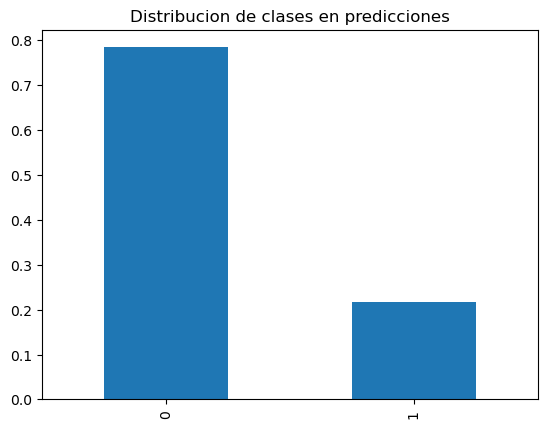


Constant model (predicts only 0s):  0.7965


In [ ]:
# Calculates the accuracy value on the validation set
model_tree = DecisionTreeClassifier(random_state=12345)

cv_scores = cross_val_score(model_tree, features_train, target_train, cv=5, scoring='f1')

print('F1 Score por fold: ', cv_scores)
print('F1 Score promedio (cross-validation):', cv_scores.mean())
print('F1 Score std (variabilidad entre folds):', cv_scores.std())

model_tree.fit(features_train, target_train)
predicted_valid_tree = model_tree.predict(features_valid)


accuracy_valid_tree = accuracy_score(target_valid, predicted_valid_tree)

print(f"\nAccuracy Valid Decision Tree Classifier: {accuracy_valid_tree}\n")

print('\nConfusion Matrix: ', confusion_matrix(target_valid, predicted_valid_tree))
print('\nRecall Score: ', recall_score(target_valid, predicted_valid_tree))
print('\nPrecision Score: ', precision_score(target_valid, predicted_valid_tree))
print('\nF1 Score: ', f1_score(target_valid, predicted_valid_tree))

# Frequency test
predicted_valid_series = pd.Series(predicted_valid_tree)
class_frequency_series = predicted_valid_series.value_counts(normalize=True)

print("\nRelative frequencies:")
print(class_frequency_series)

class_frequency_series.plot(kind='bar', title="Distribucion de clases en predicciones")
plt.show()

# Constant model to verify learn patterns
target_pred_constant_tree = pd.Series(0, index=target_valid.index)
print("\nConstant model (predicts only 0s): ", accuracy_score(target_valid, target_pred_constant_tree))


Accuracy Valid Decision Tree Classifier: 0.77

Relative frequencies:  0    0.7095
1    0.2905
Name: proportion, dtype: float64

Constant model:  0.7963

Confusion Matrix:  [[1276  317]
 [ 143  264]]

Recall Score:  0.6486486486486487

Precision Score:  0.45438898450946646

F1 Score:  0.5344129554655871


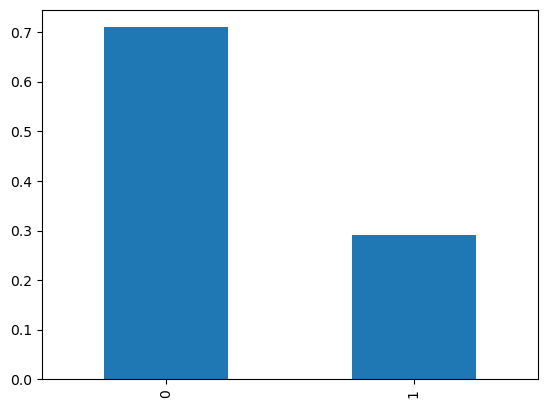

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 3
)

features_upsampled_scaled = scaler.transform(features_upsampled)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled_scaled, target_upsampled)
predicted_valid_logistic = model.predict(features_valid_scaled)

accuracy_valid_logistic = accuracy_score(target_valid, predicted_valid_logistic)

print(f"Accuracy Valid Decision Tree Classifier: {accuracy_valid_logistic}\n")

# Frequency test
predicted_valid_series_logistic = pd.Series(predicted_valid_logistic)
class_frequency_series_logistic = predicted_valid_series_logistic.value_counts(normalize=True)

print("Relative frequencies: ", class_frequency_series_logistic)

class_frequency_series_logistic.plot(kind='bar')

# Constant model to verify learn patterns
target_pred_constant_logistic = pd.Series(0, index=target.index)
print("\nConstant model: ", accuracy_score(target, target_pred_constant_logistic))
print("\nConfusion Matrix: ", confusion_matrix(target_valid, predicted_valid_logistic))
print("\nRecall Score: ", recall_score(target_valid, predicted_valid_logistic))
print("\nPrecision Score: ", precision_score(target_valid, predicted_valid_logistic))
print("\nF1 Score: ", f1_score(target_valid, predicted_valid_logistic))

Accuracy Valid Decision Tree Classifier: 0.752

Relative frequencies:  0    0.6805
1    0.3195
Name: proportion, dtype: float64

Constant model:  0.7963

Confusion Matrix:  [[1229  364]
 [ 132  275]]

Recall Score:  0.6756756756756757

Precision Score:  0.4303599374021909

F1 Score:  0.5258126195028681


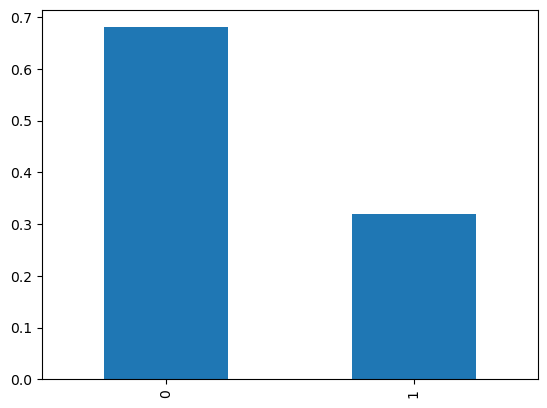

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.3
)

features_downsampled_scaled = scaler.transform(features_downsampled)

# Train model 
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled_scaled, target_downsampled)
predicted_valid_logi_down = model.predict(features_valid_scaled)

accuracy_valid_logi_down = accuracy_score(target_valid, predicted_valid_logi_down)

print(f"Accuracy Valid Decision Tree Classifier: {accuracy_valid_logi_down}\n")

# Frequency test
predicted_valid_series_logi_down = pd.Series(predicted_valid_logi_down)
class_frequency_series_logi_down = predicted_valid_series_logi_down.value_counts(normalize=True)

print("Relative frequencies: ", class_frequency_series_logi_down)

class_frequency_series_logi_down.plot(kind='bar')

# Constant model to verify learn patterns
target_pred_constant_logi_down = pd.Series(0, index=target.index)
print("\nConstant model: ", accuracy_score(target, target_pred_constant_logi_down))
print("\nConfusion Matrix: ", confusion_matrix(target_valid, predicted_valid_logi_down))
print("\nRecall Score: ", recall_score(target_valid, predicted_valid_logi_down))
print("\nPrecision Score: ", precision_score(target_valid, predicted_valid_logi_down))
print("\nF1 Score: ", f1_score(target_valid, predicted_valid_logi_down))

F1 score with adjusted threshold:  0.6033057851239669

Accuracy Valid Decision Tree Classifier: 0.86

Relative frequencies:  0    0.8835
1    0.1165
Name: proportion, dtype: float64

Constant model:  0.7963

Confusion Matrix:  [[1540   53]
 [ 227  180]]

Recall Score:  0.44226044226044225

Precision Score:  0.7725321888412017


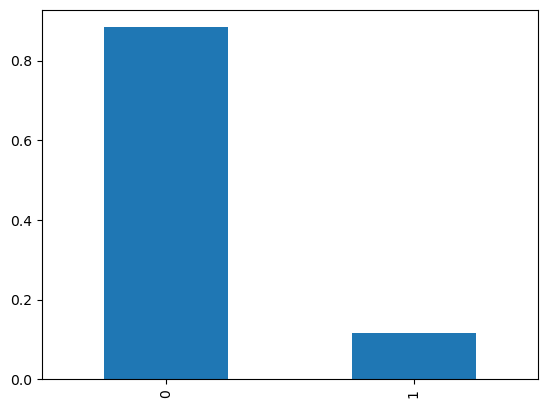

In [ ]:
# Train model 
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=300)
model_forest.fit(features_train, target_train)
predicted_valid_forest = model_forest.predict(features_valid)
probs_valid_forest = model_forest.predict_proba(features_valid)[:,1]

threshold = 0.4
preds_adjusted = (probs_valid_forest >= threshold).astype(int)

print('F1 score with adjusted threshold: ', f1_score(target_valid, preds_adjusted))

accuracy_valid_forest = accuracy_score(target_valid, predicted_valid_forest)

print(f"\nAccuracy Valid Decision Tree Classifier: {accuracy_valid_forest}\n")

# Frequency test
predicted_valid_series_forest= pd.Series(predicted_valid_forest)
class_frequency_series_forest = predicted_valid_series_forest.value_counts(normalize=True)

print("Relative frequencies: ", class_frequency_series_forest)

class_frequency_series_forest.plot(kind='bar')

# Constant model to verify learn patterns
target_pred_constant_forest = pd.Series(0, index=target.index)
print("\nConstant model: ", accuracy_score(target, target_pred_constant_forest))
print("\nConfusion Matrix: ", confusion_matrix(target_valid, predicted_valid_forest))
print("\nRecall Score: ", recall_score(target_valid, predicted_valid_forest))
print("\nPrecision Score: ", precision_score(target_valid, predicted_valid_forest))

I use DecisionTreeClassifier, LogisticRegression (with upsampling and downsampling techniques to balance classes) and RandomForestClassifier to work with desbalanced classes, I used training and validate methods to avoid overfitting, and I find out that the RandomForestClassifier was the best model having a f1-score of 0.603, with a precision of 0.77 which is very high, the main metric used is the f1 Score that represents precision and recall, and even though the recall was low, the precision was very high which make the model balanced and reliable 

4. Realiza la prueba final.

In [ ]:
final_model = RandomForestClassifier(random_state=12345, class_weight='balanced')

# Finds the best hyperparameters combination
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,2]
}

grid_search = GridSearchCV(
    estimator=final_model,
    param_grid= param_grid,
    scoring='f1',
    cv=3,
    n_jobs=1,
    verbose=1
)

grid_search.fit(features_train, target_train)

best_model = grid_search.best_estimator_
print('Mejores hiperparametros encontrados:', grid_search.best_params_)

predicted_test = best_model.predict(features_test)
probabilities_test = best_model.predict_proba(features_test)[:, 1]

threshold = 0.4
preds_adjusted = (probabilities_test >= threshold).astype(int)

print('F1 Score (test): ', f1_score(target_test, preds_adjusted))
print('AUC-ROC (test): ', roc_auc_score(target_test, probabilities_test))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores hiperparametros encontrados: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
F1 Score (test):  0.583044982698962
AUC-ROC (test):  0.8696354289574628
